# RANDOM FOREST RESEARCH!

https://academic.oup.com/mnras/article/476/3/3974/4907985

https://watermark.silverchair.com/sty511.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAsgwggLEBgkqhkiG9w0BBwagggK1MIICsQIBADCCAqoGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM0Ac-VEZECgPL_3nyAgEQgIICe4w7zTh7Rsal3GzwxA3QbVQiZSucT4ZCIGt8xEajVzr0izG25q4mgWRleQczyLk_ERJyWOBLpuOWM18kXuAWTBwfC78eUCzowwhtTJT0SutR2gZ6JvA_o-pHl6RoejzaM3UkKNGAcV28nJiCOqtrCtZ2TsKHjMqEYvVfnXRT8D77q7jLOkan669bymVgUlDJpWrvw52MxP5aO_SD3iz9KjM9gs7Xe3LSrGBQHHJW-7XRdieXh5SKPZQMW21rLD8koP2vYuvLb2Tb6F6azl3hrYelY49wh3xtMBE0gLydQBi-gN87CPaHAY7xlLgNh_TNch315ZWLTfn1ifALoYcWhLiZXTQWAuk84IhMVw0a2hVZwaA7Lda35qEwV61NJsNvR_Rn9JkhUU5srrEdULTpn_gWsIAL3nDE1sXJTTD9KI-Cagx78ak42r6No6DMdheca8Uxj1DBV8xGY_tihx1L01639wFwgWtyPSmWJd7ZKrPrXdONtNLbjih0IH71CPvYElSPsj2ucamjTXjgmtWvz4KWwIEnzrgpzU2nzgL5B2_Ky83sRFG4fB9UTlsAR6UzLy7OSYOJkymFUmYXn_S2uq5E_V7j5Q8ON4o65XS8q7xD2LIFlMM1OkoIaB-W-tc1hqXXY68NJzuMwGrHxXSKYowKpYYF4EGgo2q_r3S3kzMjMpG8R_wvooAuBvXKEDZXNG2ZkfjHkYLJdTUXUrIHqT9I39ORkLYur92_nDzMHVb93NUBrfVPPaNxXih5KJAkEPD2tvnwP82SktcIRQokY_FQN6fjBZtj-0s9cxAuC3YcnZU4suBzY4xbCC5wV4nEObQLjy-1b25J2oqL

https://www.google.com/search?q=random+forest+spectra+classifier+astronomy&rlz=1C1VDKB_enUS1006US1006&sxsrf=ALiCzsYZRbW0P1i-hPtXdjjvYDN5zNVhqA%3A1669615767817&ei=l1CEY7nBMdasqtsPj8q7oAs&ved=0ahUKEwj56IG2m9D7AhVWlmoFHQ_lDrQQ4dUDCBA&uact=5&oq=random+forest+spectra+classifier+astronomy&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCAAQogQyBQgAEKIEMgUIABCiBDIFCAAQogQyBQgAEKIEOgoIABBHENYEELADOgcIIxCwAhAnOgQIIxAnOgcIABAeEKIESgQIQRgASgQIRhgAUK4DWNAmYLcsaAFwAXgAgAFqiAGjB5IBBDEwLjGYAQCgAQHIAQjAAQE&sclient=gws-wiz-serp


https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

https://www.aanda.org/articles/aa/full_html/2015/12/aa25752-15/aa25752-15.html

https://towardsdatascience.com/predicting-stars-galaxies-quasars-with-random-forest-classifiers-in-python-edb127878e43

http://ned.ipac.caltech.edu/level5/March19/Baron/Baron2.html

https://www.aanda.org/articles/aa/abs/2022/11/aa44116-22/aa44116-22.html

https://github.com/topics/notes-template

In [ ]:
pip install tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os 

# Imports added from modifying the original code
import random
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, Column, join
from hetdex_tools.get_spec import get_spectra

2023-02-08 22:00:04.350181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 22:00:04.494494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 22:00:04.494524: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-08 22:00:05.255708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Keras is a deep learning API written in Python, running on top of ther machine learning platform TensorFlow. Keras was developed with a focus on enabling fast experimentation.

So Keras is a high-level neural network library that runs on top of TensorFlow. Keras is more user friendly because it's built in Python.

In [2]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import History 

Comments and notes by me (Nick D) :) just to help me understand what's going on.

Callbacks: A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

Callbacks can be used to:
   * Monitor metrics by writing TensorBoard logs
   * Periodically save model to disk drive
   * Do early stopping
   * Get internal states and stats during training
   * and more!

In [3]:
# This is creating a 'History' callback object. This object keeps track of the accuracy, loss and other training metrics
# for each epoch in the memory.
# Not 100% sure, but it seems like this is what allows the code to make plots later on.
history = History()

In [4]:
# Not entirely sure what the number means. Must be a naming convention about what her cuts were in the data
# after she normalized
#training_index = "31_cut"
training_index = "nick_test"

### Opening HDR3 Catalog and converting it into a Df

In [5]:
# Opening HDR3 detections catalog and converting it into a pandas DF
# HDR3 is detections HETDEX found
# Using HDR3 NEP and not H20 NEP because we can make SN cuts!
HDR_source_cat = fits.open('/home/jovyan/Hobby-Eberly-Telesco/hdr3/catalogs/source_catalog_3.0.1.fits', memmap = True)
HDR3_data = HDR_source_cat[1].data
HDR3_DF = pd.DataFrame(HDR3_data, columns=HDR3_data.columns.names)

# Columns we will then take from the entire data set (it was huge so we needed to determine what we wanted to look at specifically).
# As the name suggests, these are the ones that are useful to us!
useful_hdr3_cols = ['source_id', 'detectid',  'selected_det', 'ra_mean', 'dec_mean', 'fwhm', 'shotid', 'field',  'ra', 'dec', 'wave', 'wave_err', 'flux', 'flux_err', 'sn', 'sn_err', 'chi2', 'chi2_err',
'linewidth', 'linewidth_err', 'plya_classification', 'z_hetdex', 'z_hetdex_conf', 'combined_plae']

# From the original DFs, taking the useful columns
reduced_hdr3_df = HDR3_DF.loc[:, useful_hdr3_cols]

### Filtering data

In [6]:
# Removing data from before 2017 because it isn't good (not useful to us)
# No need to do this for H20 NEP
removed_bad_shots_hdr3_df = reduced_hdr3_df[reduced_hdr3_df.shotid.values >= 20180000000]

# This will give high confidence detections. Something we would want to do also. What is sn threshold that Valentina's code is having trouble with.
# Reason why, we want high-confidence Lya. If we are very confident sn and another filter, then that's what we consider high-conf lya.
# Once noise and high-confidence sample. We can start exanping on valentina's code and do our own stuff
# We can start with high SN > 6, and slowly decrease to SN > 5
hdr3_signal_to_noise_interval = removed_bad_shots_hdr3_df[removed_bad_shots_hdr3_df['sn'] > 6]


# Now I just take the sources stricly in the NEP field
hdr3_nep = hdr3_signal_to_noise_interval[hdr3_signal_to_noise_interval['field'] == 'nep']

## Checking for duplicates in random sample!

### Notes on code for duplicates (for myself and future reference)
* idx is the return value of indices that are the closest objects to each of the coordinates in hdr3_skycoords
* sep2 is the on-sky separation between the closest match for each element in this object in catalogcoord.
* dist3d the 3D distance between the closest match for each element in this object in catalogcoord. Shape matches this object.

For our purposes we only use idx and sep2.
We use sep2 to check for sources that have a separation of at least 1 arcsecond between them.
We are defining duplicates as sources that are closer than 1 arcsecond.
So the following code basically says, in the idx array give me the SkyCoords which
have a separation greater than 1 arcsecond. The reason I had to use idx was so that I could
have the indexes of the SkyCoords we wanted to keep which I later use to build a non-duplicate SkyCoord object
by making a list of all the skycoords with those idx and then turning that list into a SkyCoord object

In [7]:
# Turn array of hdr3 ra and dec into a SkyCoord object
hdr3_skycoords = SkyCoord(hdr3_nep['ra'] * u.deg, hdr3_nep['dec'] * u.deg)

In [8]:
hdr3_nep

,source_id,detectid,selected_det,ra_mean,dec_mean,fwhm,shotid,field,ra,dec,...,sn,sn_err,chi2,chi2_err,linewidth,linewidth_err,plya_classification,z_hetdex,z_hetdex_conf,combined_plae
123573,3010000123988,3001270559,True,274.088135,66.040260,1.592655,20180712015,nep,274.088165,66.040245,...,15.370000,0.49,1.03,0.22,2.74,0.20,0.001000,2.859134e-01,0.900000,0.006026
123575,3010000123958,3001270581,False,274.175995,66.037384,1.592655,20180712015,nep,274.175690,66.037048,...,8.460000,0.54,1.85,0.23,4.94,1.09,0.481801,-1.708075e-07,0.900000,37.005638
123576,3010000124208,3001270582,False,274.162079,66.038780,1.592655,20180712015,nep,274.161621,66.038643,...,7.680000,0.55,1.54,0.23,5.78,1.41,0.365499,-3.441763e-07,0.900000,1000.000000
123577,3010000124208,3001270587,True,274.162079,66.038780,1.592655,20180712015,nep,274.162598,66.038918,...,9.448597,0.65,1.37,0.22,7.42,1.30,0.558203,-3.441763e-07,0.900000,38.938046
123578,3010000124207,3001270609,True,274.159973,66.039505,1.592655,20180712015,nep,274.159973,66.039505,...,8.370000,0.54,2.50,0.21,3.70,1.33,0.001000,-3.534751e-07,0.800000,0.023592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418105,3010001422113,3013779171,False,273.544403,66.694489,1.247442,20210827008,nep,273.544403,66.694389,...,7.850000,0.73,1.75,0.23,8.56,2.04,0.174392,-4.583050e-07,0.900000,0.006862
1418107,3010001422113,3013779177,False,273.544403,66.694489,1.247442,20210827008,nep,273.544495,66.694748,...,6.960000,0.77,1.00,0.22,9.39,1.97,0.334173,-4.583050e-07,0.900000,0.013657
1418111,3010001422286,3013779202,True,273.814728,66.828026,1.247442,20210827008,nep,273.814728,66.828026,...,14.180000,0.47,1.02,0.22,2.71,0.19,0.086202,2.471672e-01,0.193106,0.188361
1418112,3010001422126,3013779217,False,273.818481,66.830521,1.247442,20210827008,nep,273.818542,66.830482,...,7.120000,0.71,2.11,0.22,6.83,2.28,0.362860,-4.308786e-07,0.900000,388.447601


In [9]:
# Use match_to_catalog with 2 as nearest neighbor to check the catalog against itself to find duplicates
idx, sep2, dist3d = hdr3_skycoords.match_to_catalog_sky(hdr3_skycoords, 2)

# Check if SkyCoords have a separation greater than 1 arcsecond, and get the indeces of those
# Keeping everything that has a separation greather than 1 arcsecond
skycoord_sep_checker = idx[sep2 > 1*u.arcsecond]

# initialize list to fill with SkyCoords, for loop below does that
# NOTE: possibly look into not using python loops as they are slow!
skycoord_ls = []
for num in skycoord_sep_checker:
    skycoord_ls.append(hdr3_skycoords[num])
    
hdr3_no_duplicates_SkyCoord = SkyCoord(skycoord_ls)

# Oscar's plan
### (Saving cause slack deletes messages sometimes)
Oh I do not think you want to input your noise sample through Valentina’s code, cause I do not think Valentina trained her encoder with that. What we would want to do is take a random sample of sources in the NEP field, run it through Valentina’s code and then select the output that her code says are high-z. Then we would run this “high-z” sample through your noise separator classification.
So it’ll be a two step process where you would test and train your ML algorithm using random forrest on LAEs and noise, optimize it so it has the highest accuracy possible.
Once you are comfortable with your ML algorithm then we do what i mentioned above, where we take some random sources, maybe we could apply some cuts to enhance the sample, in the NEP field run it through Valentina’s code select what her code says are high-z sources and then run those high-z sources through your ML algorithm and see which of those are actual LAEs and which are noise

# TAKES A LONG TIME. SKIP IF ALREADY HAVE A SAVED VERSION Extracts a random sample of sources in NEP. 

In [ ]:
# make it 1300, will take a very long time to run!
# making it 1300 because I will later check for duplicates! Want to make sure I have some wiggle room and don't go under 1000
    # Use wavelength to check, if its within a couple angstroms of each other.
    # Could use detectID as well.
samples_amount = 1300

# Initialize my 2d list which will later be turned into an array
# the range is just how many columns (I THINK DOUBLE CHECK THIS)
random_nep_LS = [[0] * 1 for i in range(samples_amount)]

shotid_LS = [0 * 1 for i in range(samples_amount)]

counter = 0

while counter < samples_amount:
    #pick a random coordinate from the skycoord object
    random_coord = hdr3_no_duplicates_SkyCoord[random.randint(0, hdr3_skycoords.size)]
    # extract spectra at this random coordinate and append to list, can't append to np array because of 
    # data type issues will convert to array after loop!
    extraction = get_spectra(random_coord)
    
    # Exctracting only if we have 1 spectra. 
    # Reasoning for this is because if we have more than 1 the shape of the spectra array changes in dimension
    # Asked gene and it's okay to only exctract if one spectra because HETDEX detects are only 1 spectra
    if len(extraction) == 1:
             
        squeezed_extraction = np.squeeze(extraction['spec'].value)
        random_nep_LS[counter] = squeezed_extraction
        shotid_LS[counter] = extraction['shotid'].value
        
        counter += 1
    else:
        continue
    
random_nep_spectra = np.array(random_nep_LS)
random_nep_shotids = np.array(shotid_LS)



In [ ]:
#np.save(f"random_nep_sample_{samples_amount}",  )

In [ ]:
# Just a new save, didn't want to risk messing up the old one
#np.save(f"random_nep_sample_{samples_amount}pt2", random_nep_spectra)
#np.save(f"random_nep_shotids_{samples_amount}pt2", random_nep_shotids)

In [10]:
# Loading in spectra sample
# The allow pickle part uses the pickle module which is not secure against maliciously constructed data
# Don't allow pickle if you don't trust the source, I do so it doesn't matter to me
# I have to do the allow_pickle = True for the code to not give me an error anyway
NEP_spec = np.load("random_nep_sample_1300pt2.npy", allow_pickle = True)

In [11]:
NEP_detectID = np.load("random_nep_shotids_1300pt2.npy", allow_pickle = True)

In [12]:
NEP_spec[974]

array([ 4.97239399,  4.97781573,  4.98321598, ..., 18.26721529,
       18.26957254, 18.27190535])

In [13]:
NEP_detectID

array([[20210510027],
       [20190506016],
       [20210617016],
       ...,
       [20180913008],
       [20210517024],
       [20190825016]])

In [14]:
NEP_spec

array([[ 2.12885488,  2.13102529,  2.13318934, ...,  2.74846488,
         2.74853338,  2.74860111],
       [ 0.63213673,  0.63077807,  0.62941943, ...,  1.6854173 ,
         1.68542767,  1.68543791],
       [ 1.80624617,  1.80601772,  1.8057713 , ...,  1.01938544,
         1.01930483,  1.01922501],
       ...,
       [14.51305184, 14.53364363, 14.55417553, ..., 38.84887497,
        38.852476  , 38.85603765],
       [ 0.2522168 ,  0.25407142,  0.25592504, ...,  2.29254241,
         2.29273089,  2.29291743],
       [ 2.22458229,  2.22572453,  2.22685947, ..., 10.95365891,
        10.9533971 , 10.95313759]])

In [15]:
# # Loading in spectra samples
# star_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/star_spec_reduced.npy") 
# agn_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/all_agn_no_duplicates.npy")
# lowz_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/lowz_no_duplicates.npy")
# gal_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/gal_sample.npy")

In [16]:
# This function checks for nan values.
# Interestingly enough, when you do nan != nan, you get True. Becuase NaN is unequal with anything.
# But with numbers, you'll get false.
def isNaN(num):
    return num != num

### Could also use numpy isnan

In [17]:
# If there are any values in the imports that are 'nan' (Not a Number) we remove them.
# Go through each value in matrix and check if NaN
def remove_nan(file):
    for i in range(0,len(file)):
        for j in range(0,len(file[i])):
            if isNaN(file[i][j]):

                # if value is nan, make the value equal to 0.0001
                # I'm assuming this was to avoid errors
                file[i][j]=0.00001

# remove_nan(star_spec)
# remove_nan(agn_spec)
# remove_nan(lowz_spec)
# remove_nan(gal_spec)
# Adding NEP files to the remove NaN function calls
remove_nan(NEP_spec)

In [18]:
# random.seed(2) will make the random numbers predictable, so random numbers, but the same random numbers from the same set/seed
# so I'll get the same random numbers everytime, until I change the seed
np.random.seed(2)
# random.shuffle will shuffle the values in an array or list. Like shuffling a deck of cards
# I wonder why she only shuffled starspec.

# np.random.shuffle(star_spec)
np.random.shuffle(NEP_spec)

Tying to split between testing and training below. scikit learning has something to make randomize data set and training sets.

In [ ]:
# # concatenate just joins arrays

# all_images = np.concatenate((star_spec[::90],agn_spec,lowz_spec,gal_spec))

# # making a training set

# train_images = np.concatenate((star_spec[::90][:433],agn_spec[:444],lowz_spec[:837],gal_spec[:254]))

# #train_images = agn_spec[:433]
# #np.random.shuffle(train_images)

In [ ]:
# all_images.shape

In [ ]:
# train_images.shape

In [ ]:
# # not sure what these val_images are, it seems to be the opposite half of the train_images.
# val_images = np.concatenate((star_spec[::90][433:],agn_spec[444:],lowz_spec[837:],gal_spec[254:]))
# #val_images = agn_spec[433:]
# #np.random.shuffle(val_images)

Largest trunk is training, validation is smaller, and test is smallest! Most places I looked Training much bigger by a decent margin. So I'm going from Training: 50, Valid: 30, Test: 20 to Training: 60, Valid: 30, Test = 10

Training = 60

validation = 30

test = 10

Main difference only training on training set. Others are to test how well it works.

# Definition of Train-Valid-Test Split
(https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c)
Train-Valid-Test split is a technique to evaluate the performance of your machine learning model — classification or regression alike. You take a given dataset and divide it into three subsets. A brief description of the role of each of these datasets is below.

## Train Dataset
Set of data used for learning (by the model), that is, to fit the parameters to the machine learning model
## Valid Dataset
Set of data used to provide an unbiased evaluation of a model fitted on the training dataset while tuning model hyperparameters.
Also play a role in other forms of model preparation, such as feature selection, threshold cut-off selection.
## Test Dataset
Set of data used to provide an unbiased evaluation of a final model fitted on the training dataset.

### My splitting between training, validation. and testing

In [19]:
from sklearn.model_selection import train_test_split

Below this is code that splits the data into training, validation and testing. However Valentina's code only uses training and validation. So I will do that as well!

In [20]:
# Here train_test_split takes in an array (NEP_spec)
# a test_size which is just a float from 0 to 1 to tell it how to split up the train and tests
# and random_state which works similar to the .shuffle. It helps control the shuffling and helps us reproduce outputs
# imported from

# Want to split the data into 60:30:10 for train:valid:test dataset
# If we use sklearn then this takes 3 steps, I found a package called fast_ml
# that did this in one step, but felt that using sklearn was better since it was more popular
# and so I could get help easier if something went wrong

# First we split the data into training, and a remaining dataset
#NEP_train, NEP_valid = train_test_split(NEP_spec, test_size = 0.4, random_state = 42)

# Now since we want test to be 10% of overall data, so I take 25% of the NEP_valid (1/4 of 40 = 10)
#NEP_valid, NEP_test = train_test_split(NEP_valid, test_size = 0.25, random_state = 42)

# print("NEP_train.shape", NEP_train.shape)
# print("NEP_valid.shape", NEP_valid.shape)
# print("NEP_test.shape", NEP_test.shape)


#NEP_train, NEP_valid, NEP_test = train_valid_test_split(NEP_spec, train_size = 0.6, valid_size = 0.3, test_size = 0.1, random_state=42)

In [21]:
# Valentina's validation is 1/4th the size of her traning, so I will do that as well
# and make my training 75% of the whole data set.
NEP_train, NEP_valid = train_test_split(NEP_spec, train_size = 0.75, random_state = 42)

print("NEP_train.shape", NEP_train.shape)
print("NEP_valid.shape", NEP_valid.shape)

NEP_train.shape (975, 1036)
NEP_valid.shape (325, 1036)


In [22]:
# This function will normalize the data.
# The idea is, there is such a large range of sources so it may be simpler for the algorithm to recognize sources
# if they are between 0 and 1.
# Dividing by the largest number preserves the information but scales it down.
# If we don't do this the sources could go from a very large number to a small one, which makes it harder for the algorithm
def Norm(data):
    new_data = []
    for spec in data:
        #print('spec_before', spec)
        spec = spec/spec.max()
        #print('spec_after', spec)
        #print('spec.max', spec.max())
        new_data.append(spec)
    return np.array(new_data)

In [23]:
# Normalizing both data sets
# train_images = Norm(train_images)
# val_images = Norm(val_images)

NEP_train = Norm(NEP_train)
NEP_valid = Norm(NEP_valid)

Cutting out left and right ends, because when making inspection there can be weird things on the left most end.

In [24]:
# # Cutting out left and right ends, because when making inspection there can be weird things on the left most end.
# # As of right now, not sure if I need to cut anything.
# # Making cuts of the image sets and then normalizing them.

# train_cut = train_images[:,88:1002]
# val_cut = val_images[:,88:1002]
# train_cut = Norm(train_cut)
# val_cut = Norm(val_cut)

In [25]:
# train_images.shape

In [26]:
# train_cut.shape

In [27]:
latent_dim = 30
act = 'sigmoid'

In [28]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          #layers.InputLayer(input_shape=(1036)),
          layers.Dense(436, activation=act,name="e1"),
          #layers.Dropout(0.3),
          #layers.Dense(136, activation=act, name ='e2'),
          #BatchNormalization(),
          layers.Dropout(0.3),
          layers.Dense(latent_dim, activation=None, name = "e3"),
        ])
        self.decoder = tf.keras.Sequential([
          #layers.InputLayer(input_shape=(latent_dim,)),
          #layers.Dense(136, activation=act,name = "d1"),
          layers.Dense(436, activation=act,name = "d2"),
          #BatchNormalization(),
          layers.Dense(1036, activation=None,name = "d3")
        ])#914 for cut. 1036 for all

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [29]:
autoencoder = Autoencoder(latent_dim)
#autoencoder.build(input_shape=np.shape(train_images))
epoch = 500

2023-02-08 22:01:46.214862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-08 22:01:46.214897: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 22:01:46.214917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-nimda16): /proc/driver/nvidia/version does not exist
2023-02-08 22:01:46.215205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
adg = tf.keras.optimizers.Adagrad(
    learning_rate=0.01)

In [31]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005)

In [32]:
def loss1(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    d = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
    #tf.print(d, [d], "Inside loss function")
    #tf.print(d.shape)
    return d

autoencoder.compile(optimizer=adam, loss=loss1)#es.MeanSquaredError())

try:
    os.mkdir(f"models/training{training_index}")
    checkpoint_path = f"models/training{training_index}/cp_{training_index}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
except:
    checkpoint_path = f"models/training{training_index}/cp_{training_index}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

In [33]:
# # ORIGINAL FROM VALENTINA'S CODE!!
# # Create a callback that saves the model's weights

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
# #autoencoder.summary()
# #autoencoder.fit(train_images, train_images,
#  #               epochs=10,
#   #              shuffle=True,
#    #             validation_data=(val_images,val_images))
    
    
# hist = autoencoder.fit(train_cut, train_cut,
#                 epochs=epoch,
#                 shuffle=True,
#                 validation_data=(val_cut,val_cut),
#                 callbacks=[cp_callback])

In [34]:
NEP_train.shape

(975, 1036)

In [35]:
NEP_valid.shape

(325, 1036)

In [36]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
#autoencoder.summary()
#autoencoder.fit(train_images, train_images,
 #               epochs=10,
  #              shuffle=True,
   #             validation_data=(val_images,val_images))
hist = autoencoder.fit(NEP_train, NEP_train,
                epochs=epoch,
                shuffle=True,
                validation_data=(NEP_valid,NEP_valid),
                callbacks=[cp_callback])


Epoch 1/500
31/31 [==============================] - ETA: 0s - loss: 0.1107
Epoch 1: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 2s 19ms/step - loss: 0.1107 - val_loss: 0.0498
Epoch 2/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0316
Epoch 2: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0296 - val_loss: 0.0184
Epoch 3/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0190
Epoch 3: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0186 - val_loss: 0.0181
Epoch 4/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0182
Epoch 4: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0182 - val_loss: 0.0169
Epoch 5/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0

28/31 [==========================>...] - ETA: 0s - loss: 0.0117
Epoch 36: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 37/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0118
Epoch 37: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 38/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0117
Epoch 38: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 39/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0119
Epoch 39: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 40/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0116


25/31 [=======================>......] - ETA: 0s - loss: 0.0112
Epoch 71: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 72/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0115
Epoch 72: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 73/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0112
Epoch 73: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 74/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0113
Epoch 74: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 75/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0113


27/31 [=========================>....] - ETA: 0s - loss: 0.0110
Epoch 106: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 107/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0109
Epoch 107: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 108/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0107
Epoch 108: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 109/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0109
Epoch 109: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 110/500
27/31 [=========================>....] - ETA: 0s - loss:

Epoch 141/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0104
Epoch 141: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 142/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0106
Epoch 142: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 143/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0107
Epoch 143: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 144/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0106
Epoch 144: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 145/500
25/31 [=======================>......] - E

Epoch 176/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0101
Epoch 176: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0106
Epoch 177/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0102
Epoch 177: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 178/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0102
Epoch 178: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 179/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0102
Epoch 179: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 180/500
27/31 [=========================>....] - E

Epoch 211/500
24/31 [======================>.......] - ETA: 0s - loss: 0.0096
Epoch 211: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0105
Epoch 212/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0094
Epoch 212: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0106
Epoch 213/500
24/31 [======================>.......] - ETA: 0s - loss: 0.0096
Epoch 213: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0105
Epoch 214/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0095
Epoch 214: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0104
Epoch 215/500
27/31 [=========================>....] - E

Epoch 246/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0090
Epoch 246: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0104
Epoch 247/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0089
Epoch 247: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0104
Epoch 248/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0089
Epoch 248: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 249/500
24/31 [======================>.......] - ETA: 0s - loss: 0.0089
Epoch 249: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 250/500
23/31 [=====================>........] - E

Epoch 281/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0082
Epoch 281: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0104
Epoch 282/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0082
Epoch 282: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0104
Epoch 283/500
27/31 [=========================>....] - ETA: 0s - loss: 0.0082
Epoch 283: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0103
Epoch 284/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0083
Epoch 284: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0103
Epoch 285/500
27/31 [=========================>....] - E

Epoch 316/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0076
Epoch 316: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0075 - val_loss: 0.0103
Epoch 317/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0075
Epoch 317: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 318/500
24/31 [======================>.......] - ETA: 0s - loss: 0.0074
Epoch 318: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 319/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0075
Epoch 319: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 320/500
25/31 [=======================>......] - E

Epoch 351/500
31/31 [==============================] - ETA: 0s - loss: 0.0068
Epoch 351: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0068 - val_loss: 0.0104
Epoch 352/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0068
Epoch 352: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0104
Epoch 353/500
28/31 [==========================>...] - ETA: 0s - loss: 0.0067
Epoch 353: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 11ms/step - loss: 0.0067 - val_loss: 0.0104
Epoch 354/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0066
Epoch 354: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0067 - val_loss: 0.0104
Epoch 355/500
26/31 [========================>.....] - E

Epoch 386/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0061
Epoch 386: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0062 - val_loss: 0.0104
Epoch 387/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0062
Epoch 387: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0105
Epoch 388/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0061
Epoch 388: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0105
Epoch 389/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0062
Epoch 389: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0105
Epoch 390/500
24/31 [======================>.......] - E

Epoch 421/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0056
Epoch 421: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 422/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0056
Epoch 422: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 423/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0055
Epoch 423: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 424/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0056
Epoch 424: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 425/500
25/31 [=======================>......] - E

Epoch 456/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0052
Epoch 456: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0053 - val_loss: 0.0107
Epoch 457/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0053
Epoch 457: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0053 - val_loss: 0.0106
Epoch 458/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0052
Epoch 458: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0052 - val_loss: 0.0107
Epoch 459/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0052
Epoch 459: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0052 - val_loss: 0.0107
Epoch 460/500
25/31 [=======================>......] - E

Epoch 491/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0049
Epoch 491: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 0.0107
Epoch 492/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0048
Epoch 492: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0108
Epoch 493/500
26/31 [========================>.....] - ETA: 0s - loss: 0.0048
Epoch 493: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 0.0107
Epoch 494/500
25/31 [=======================>......] - ETA: 0s - loss: 0.0049
Epoch 494: saving model to models/trainingnick_test/cp_nick_test.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 0.0107
Epoch 495/500
28/31 [==========================>...] - E

In [37]:
# means that my matplotlib graphs will be included in the notebook, next to the code
%matplotlib inline

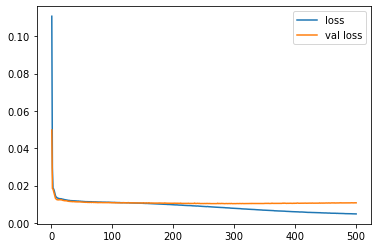

In [38]:
plt.figure()
x = np.linspace(1,epoch+1,epoch)
plt.plot(x,hist.history["loss"],label="loss")
plt.plot(x,hist.history["val_loss"],label="val loss")
plt.legend()
plt.savefig(f'Graphs/loss_{training_index}.png')
#print(np.shape(train_images))

encoded_imgs = autoencoder.encoder(NEP_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
np.save(f"encoded_{training_index}",encoded_imgs)
np.save(f"decoded_{training_index}",decoded_imgs)

encoded_val = autoencoder.encoder(NEP_valid).numpy()
np.save(f"encoded_val_{training_index}",encoded_val)

In [39]:
np.load("encoded_nick_test.npy")

array([[ 2.7128453 ,  2.6934683 , -2.896932  , ..., -5.9906383 ,
        -5.635291  , -3.6318762 ],
       [ 3.4257495 ,  1.9118977 , -1.560202  , ..., -1.553874  ,
        -3.9304602 ,  2.49379   ],
       [ 3.125207  , -0.71659875,  0.30318338, ..., -2.1682596 ,
        -4.299144  ,  0.60477495],
       ...,
       [ 2.8337865 ,  0.28991932, -1.347356  , ..., -4.5758758 ,
        -4.4836984 , -0.14965299],
       [ 1.8829945 ,  2.1978958 , -3.8403091 , ..., -4.792378  ,
        -2.4077652 , -2.7456052 ],
       [ 2.3424387 ,  1.4821758 , -0.98192465, ..., -1.7213485 ,
        -2.8790467 ,  1.9647508 ]], dtype=float32)

0.010748090222477913


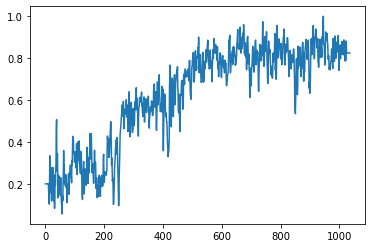

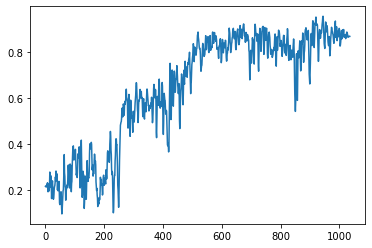

In [40]:
plt.figure()
plt.plot(NEP_train[3])
plt.savefig("OG.png")
plt.figure()
plt.plot(decoded_imgs[3])
plt.savefig("RECON.png")
print(hist.history["val_loss"][-1])